In [2]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import sympy.physics.mechanics as me
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload

In [3]:
### Equation of motion for 3D double pendulum ###

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q = me.dynamicsymbols('q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B')  # quaternion
u = me.dynamicsymbols('u1A, u2A, u3A, u1B, u2B, u3B')  # angular velocities
# l, m, g, Ixx, Iyy, Izz = sp.symbols('l m g Ixx Iyy Izz')  # 
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')
u_s = u.copy()
u = sp.Matrix(u)*1

N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')

# rotate joint by quaternion and apply angular velocities
# first joint is in the world frame center
A.orient(N, 'Quaternion', [q[0], q[1], q[2], q[3]])
A.set_ang_vel(N, u[0]*A.x + u[1]*A.y + u[2]*A.z)

# set masscenter of the first body
mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

# set the position of the joint between the two bodies
ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)

# orient second body from the first body
B.orient(A, 'Quaternion', [q[4], q[5], q[6], q[7]])
B.set_ang_vel(A, u[3]*B.x + u[4]*B.y + u[5]*B.z)
mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)
I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 1000*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 1000*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]
kindeq = []

# set kinematic differential equations - see Quaternions and Dynamics, page 9, equation 18
for i in range(2):
    kindeq.append(q[0+i*4].diff(t) - 0.5 * (-u[0+i*3]*q[1+i*4] - u[1+i*3]*q[2+i*4] - u[2+i*3]*q[3+i*4]))
    kindeq.append(q[1+i*4].diff(t) - 0.5 * (u[0+i*3]*q[0+i*4] + u[2+i*3]*q[2+i*4] - u[1+i*3]*q[3+i*4]))
    kindeq.append(q[2+i*4].diff(t) - 0.5 * (u[1+i*3]*q[0+i*4] - u[2+i*3]*q[1+i*4] + u[0+i*3]*q[3+i*4]))
    kindeq.append(q[3+i*4].diff(t) - 0.5 * (u[2+i*3]*q[0+i*4] + u[1+i*3]*q[1+i*4] - u[0+i*3]*q[2+i*4]))

eoms_cnst = sp.Matrix([[q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 - 1], 
                       [q[4]**2 + q[5]**2 + q[6]**2 + q[7]**2 - 1]])
KM = me.KanesMethod(N, q_ind=q, u_ind=u_s, kd_eqs=kindeq)
(fr, frstar) = KM.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2))

In [4]:
sp.shape(frstar)

(6, 1)

In [5]:
eoms = sp.Matrix(kindeq).col_join(fr+frstar)

In [6]:
duration = 2 # seconds
num_nodes = 21
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)

state_symbols = tuple(q+u_s)
num_states = len(state_symbols)
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [7]:
# obj_func = sp.Integral(sum(sp.Matrix(F).applyfunc(lambda e: e**2)),t)
# obj, obj_grad = create_objective_function(obj_func,
#                                           state_symbols,
#                                           specified_symbols,
#                                           tuple(),
#                                           num_nodes,
#                                           interval_value)
# obj_func

In [27]:
import opty_lib as op
import optyEngine as oe
reload (oe);
reload (op);
eul_traj,deul_traj = oe.create_trajectory(num_nodes,duration,interval_value)
quat_traj,quat_traj_guess,_,_ = oe.eul2quat_traj(num_nodes,eul_traj,interval_value)



sp_rotmat,rotmat_J,min_rotmat, min_rotmat_J = op.min_rotglob(q[0:4],q[4:8])

def obj_fun(free):
    obj = min_rotmat(np.split(free,len(q)))

    return obj

(obj_fun(quat_traj))



array([[[ 1.        ,  0.99922504,  0.98825201,  0.9459076 ,
          0.85147845,  0.70006465,  0.51004873,  0.31629858,
          0.15462477,  0.04985084,  0.01388551,  0.04985084,
          0.15462477,  0.31629858,  0.51004873,  0.70006465,
          0.85147845,  0.9459076 ,  0.98825201,  0.99922504,
          1.        ]],

       [[ 0.        ,  0.00171204,  0.0049676 ,  0.00419687,
         -0.00848226, -0.0391311 , -0.0869365 , -0.14285827,
         -0.19380979, -0.22858221, -0.24080341, -0.22858221,
         -0.19380979, -0.14285827, -0.0869365 , -0.0391311 ,
         -0.00848226,  0.00419687,  0.0049676 ,  0.00171204,
          0.        ]],

       [[ 0.        , -0.00235343, -0.01118585, -0.03000022,
         -0.05974721, -0.09552847, -0.12804491, -0.14945635,
         -0.15838151, -0.15953895, -0.15903589, -0.15953895,
         -0.15838151, -0.14945635, -0.12804491, -0.09552847,
         -0.05974721, -0.03000022, -0.01118585, -0.00235343,
          0.        ]],

       [[ 

In [19]:
import optyEngine as oe
reload (oe);
eul_traj,deul_traj = oe.create_trajectory(num_nodes,duration,interval_value)
quat_traj,quat_traj_guess,_,_ = oe.eul2quat_traj(num_nodes,eul_traj,interval_value)

def obj(free):
    min_traj = interval_value * np.sum((quat_traj_guess[:4*2*num_nodes] - free[:4*2*num_nodes])**2)
    # min_vel = 0.005*interval_value * np.sum((quat_traj_guess[4*2*num_nodes:7*2*num_nodes] - free[4*2*num_nodes:7*2*num_nodes])**2)
    min_torque = 0.00005 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:4*2*num_nodes] = 2.0 * interval_value * (free[:4*2*num_nodes] - quat_traj_guess[:4*2*num_nodes])
    # grad[4*2*num_nodes:7*2*num_nodes] = 0.005 * 2.0 * interval_value * (free[4*2*num_nodes:7*2*num_nodes] - quat_traj_guess[4*2*num_nodes:7*2*num_nodes])
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 0.00005 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [20]:
instance_constraints = [
    q[0].func(0.0) - 1,
    q[1].func(0.0) - 0,
    q[2].func(0.0) - 0,
    q[3].func(0.0) - 0,
    q[4].func(0.0) - 1,
    q[5].func(0.0) - 0,
    q[6].func(0.0) - 0,
    q[7].func(0.0) - 0,
    u_s[0].func(0.0) - 0,
    u_s[1].func(0.0) - 0,
    u_s[2].func(0.0) - 0,
    u_s[3].func(0.0) - 0,
    u_s[4].func(0.0) - 0,
    u_s[5].func(0.0) - 0,
]

for i in time:
    normQ1 = q[0].func(i)**2+q[1].func(i)**2+q[2].func(i)**2+q[3].func(i)**2-1
    normQ2 = q[4].func(i)**2+q[5].func(i)**2+q[6].func(i)**2+q[7].func(i)**2-1
    instance_constraints.append(normQ1)
    instance_constraints.append(normQ2)
instance_constraints = tuple(instance_constraints)

max_force = 10000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [21]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds={},
               integration_method='midpoint') # 

prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)

191.25789999961853


In [22]:
# initial_guess = np.zeros(prob.num_free)
initial_guess = np.random.randn(prob.num_free)*0
initial_guess[:7*2*num_nodes] = quat_traj_guess
# prob.add_option('max_iter',10000)
# prob.add_option('acceptable_tol', 1e-12)
# prob.add_option('tol', 1e-12)

In [23]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)

print(info['status_msg'])
print(info['obj_val'])

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    56822
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2020
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1616
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.10e+03 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

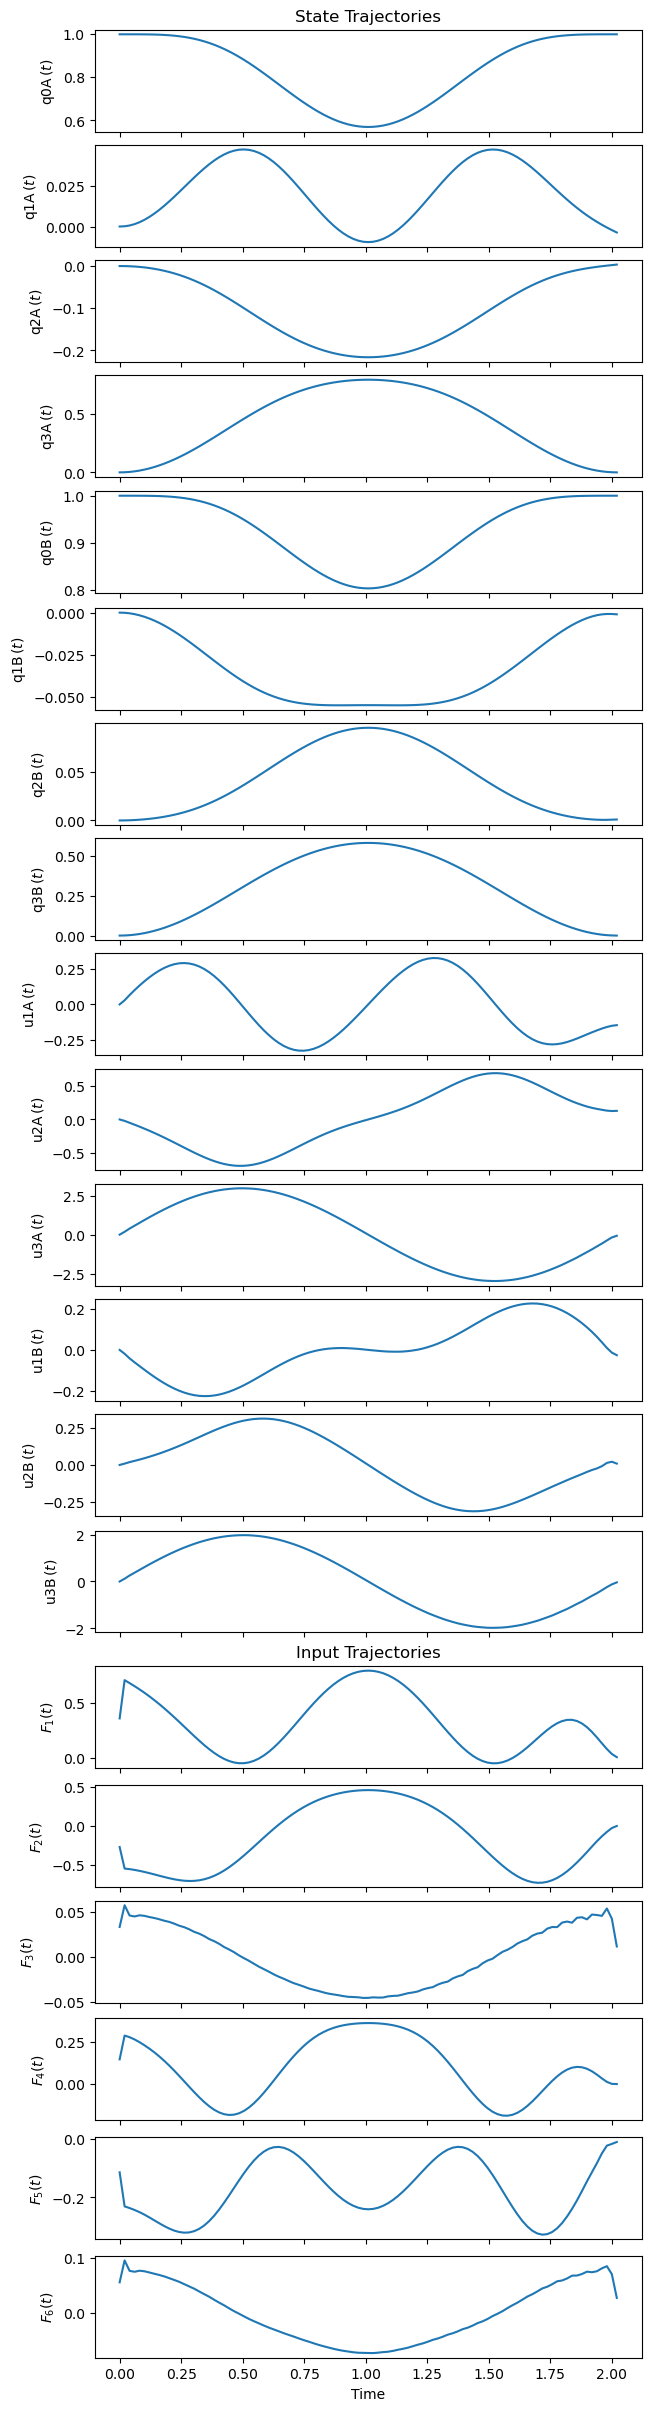

In [24]:
fig, axes = plt.subplots(20, 1, sharex=True,
                         figsize=(6.4, 0.8*30),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

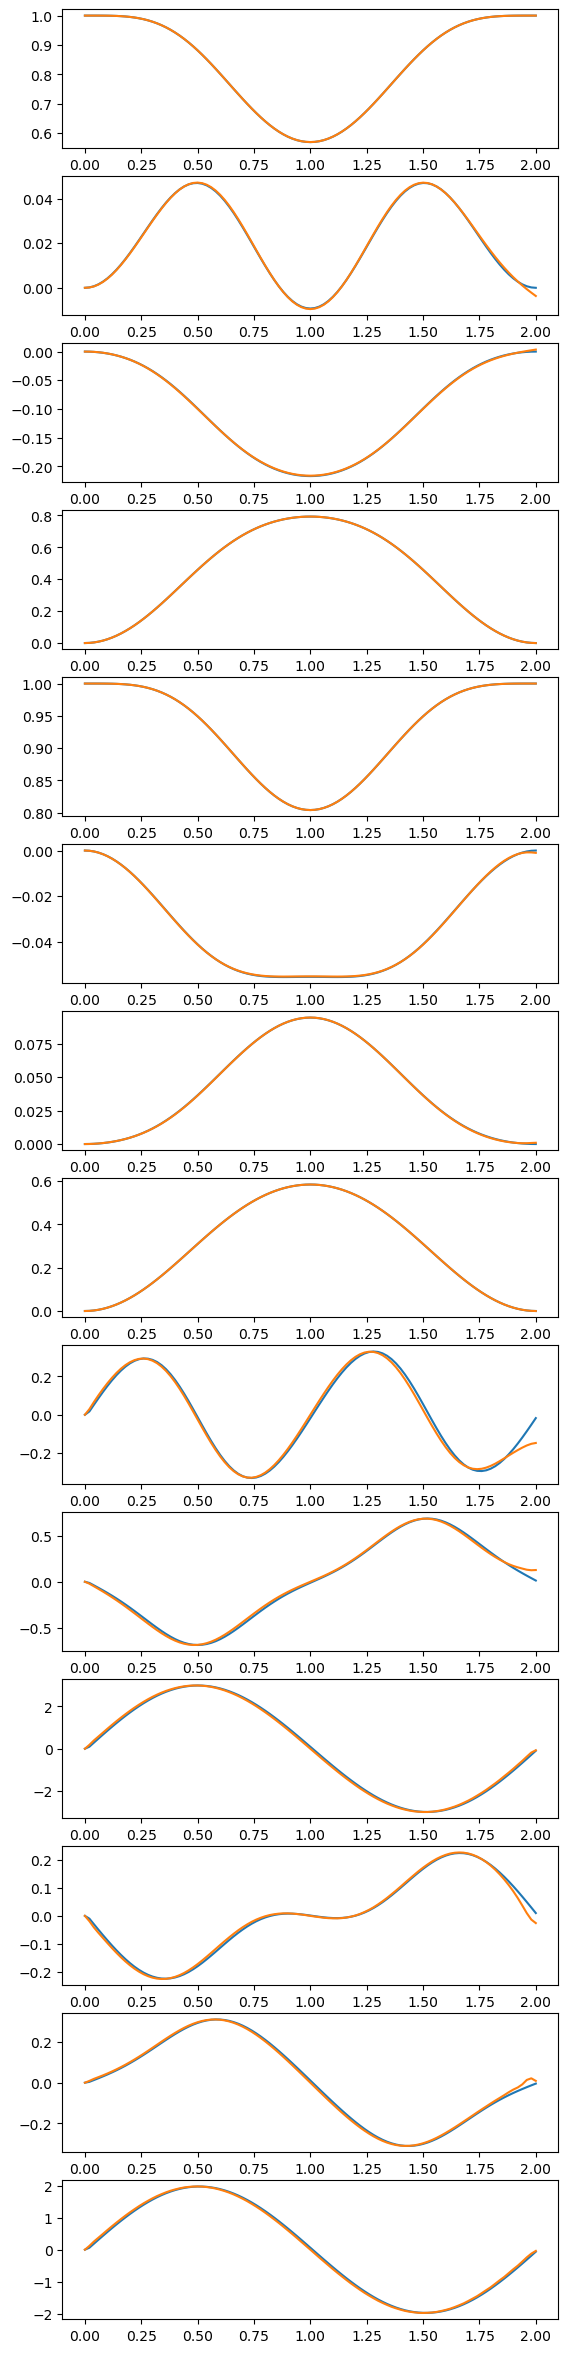

In [25]:
fig, axs = plt.subplots(14)
for j in range(14):
    axs[j].plot(time,quat_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(30)